In [95]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

## Theoretical $q^2$

In [96]:
def dGammaDsmu(q2):
    return 1.08656*10**(-6) * (1 - 0.011025/q2)**2 *np.sqrt((11.5532 - q2) * (53.8022 - q2)) * q2 * (3.10955/(q2**2 * (1 - 0.058671 * q2 + 0.000940087 * q2**2)**2) + (0.3025 * (1 + 0.0055125/q2) * (11.5532 - q2) * (53.8022 - q2))/(q2 * (1 - 0.0847084 * q2 + 0.00204891 * q2**2)**2))

def dGammaDstau(q2):
    return 1.08656*10**(-6) * (1 - 3.16128/q2)**2 *np.sqrt((11.5532 - q2) * (53.8022 - q2)) * q2 * (891.626/(q2**2 * (1 - 0.058671 * q2 + 0.000940087 * q2**2)**2) + (0.3025 * (1 + 1.58064/q2) * (11.5532 - q2) * (53.8022 - q2))/(q2 * (1 - 0.0847084 * q2 + 0.00204891 * q2**2)**2))

def dGammaDsstarmu(q2):
    return 1.08656*10**(-6) * (1 - 0.011025/q2)**2 * np.sqrt((10.595 - q2) * (55.9354 - q2)) * q2 *\
            ((0.00365313 * (10.595 - q2) * (55.9354 - q2))/(q2**2 * (1 - 0.0864443 * q2 + 0.00209712 * q2**2)**2) + (1 + 0.0055125/q2) * ((3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) - (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + \
            (3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.0828988 * np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + (3.13501 * ((0.49 * (-24.3441 + q2))/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.00929643 * (10.595 - q2) * (55.9354 - q2))/(1 - 0.0808896 * q2 + 0.00218148 * q2**2))**2)/q2))

def dGammaDsstartau(q2):
    return 1.08656*10**(-6) * (1 - 3.16128/q2)**2 * np.sqrt((10.595 - q2) * (55.9354 - q2)) * q2 *\
            ((1.04749 * (10.595 - q2) * (55.9354 - q2))/(q2**2 * (1 - 0.0864443 * q2 + 0.00209712 * q2**2)**2) + (1 + 1.58064/q2) * ((3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) - (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + \
            (3.66471/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.0828988 *np.sqrt((10.595 - q2) * (55.9354 - q2)))/(1 - 0.0860971 * q2 + 0.0020007 * q2**2))**2 + (3.13501 * ((0.49 * (-24.3441 + q2))/(1 - 0.0569352 * q2 + 0.000711092 * q2**2) + (0.00929643 * (10.595 - q2) * (55.9354 - q2))/(1 - 0.0808896 * q2 + 0.00218148 * q2**2))**2)/q2))



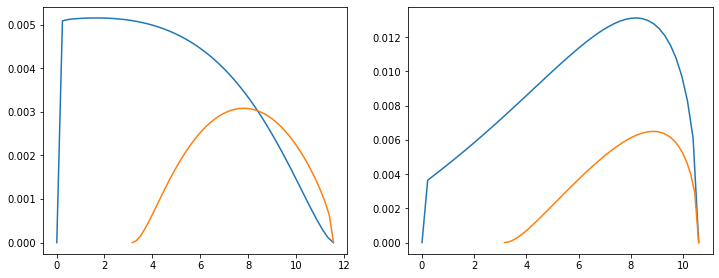

In [97]:
q2_mu = np.linspace(0.105**2, 11.5532)
q2_tau = np.linspace(1.778**2, 11.5532)
q2_star_mu = np.linspace(0.105**2, 10.595)
q2_star_tau = np.linspace(1.778**2, 10.595)

plt.figure(figsize=(12,10))
dGmu = dGammaDsmu(q2_mu)
dGtau = dGammaDstau(q2_tau)
dGstarmu = dGammaDsstarmu(q2_star_mu)
dGstartau = dGammaDsstartau(q2_star_tau)

ax1 = plt.subplot(221)
ax1.plot(q2_mu, dGmu)
ax1.plot(q2_tau, dGtau)

ax2 = plt.subplot(222)
ax2.plot(q2_star_mu, dGstarmu)
ax2.plot(q2_star_tau, dGstartau)

## Loading Data

In [98]:
epsilon_pimu = 1/100


# modes_dt = {0: {'mode': '~/Projects/LFUV/RDs/features/DsTauNu_10Noise.root', 'yields': 5.17e5}, 
#             1: {'mode': '~/Projects/LFUV/RDs/features/DsMuNu_10Noise.root', 'yields': 8.94e6},
#             2: {'mode': '~/Projects/LFUV/RDs/features/DsstarTauNu_10Noise.root', 'yields': 8.16e5}, 
#             3: {'mode': '~/Projects/LFUV/RDs/features/DsstarMuNu_10Noise.root', 'yields': 1.89e7},
#             4: {'mode': '~/Projects/LFUV/RDs/features/RDsInclusive_10Noise.root', 'yields': 2.78e6},
#             5: {'mode': '~/Projects/LFUV/RDs/features/RDsCombCascade_10Noise.root', 'yields': 8.55e6},
#             6: {'mode': '~/Projects/LFUV/RDs/features/RDsMisID_10Noise.root', 'yields': epsilon_pimu*8.51e7}
#            }

# 20noise
modes_dt = {0: {'mode': '~/Projects/LFUV/RDs/features/DsTauNu_20Noise.root', 'yields': 5.15e5}, 
            1: {'mode': '~/Projects/LFUV/RDs/features/DsMuNu_20Noise.root', 'yields': 8.79e6},
            2: {'mode': '~/Projects/LFUV/RDs/features/DsstarTauNu_20Noise.root', 'yields': 8.14e5}, 
            3: {'mode': '~/Projects/LFUV/RDs/features/DsstarMuNu_20Noise.root', 'yields': 1.85e7},
            4: {'mode': '~/Projects/LFUV/RDs/features/RDsInclusive_20Noise.root', 'yields': 2.76e6},
            5: {'mode': '~/Projects/LFUV/RDs/features/RDsCombCascade_20Noise.root', 'yields': 9.87e6},
            6: {'mode': '~/Projects/LFUV/RDs/features/RDsMisID_20Noise.root', 'yields': epsilon_pimu*9.90e7}
           }

In [99]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        df_i = file['t'].pandas.df()    
        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [100]:
tr_te_split = 0.5
df_train, df_test = load_train_test(modes_dt, tr_te_split)
# df_test, df_train = load_train_test(modes_dt, tr_te_split)
# make a copy
df_train_o, df_test_o = df_train.copy(), df_test.copy()

train size: 56582 (50.00%); test size: 56580 (50.00%)
data points per mode:  [1622, 10396, 870, 2705, 2409, 8630, 86530]


In [101]:
def relabel(x):
    if x == 0 :    # Ds tau signal
        return 0
    elif x == 1:     # Ds mu signal
        return 1
    if x == 2 :    # Ds* tau signal
        return 2
    elif x == 3:     # Ds* mu signal
        return 3
    else:         # Bkg.
        return 4
    

In [102]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [103]:
df_train.columns

Index(['iEvt', 'q2', 'miss2', 'pB', 'EB', 'pHc', 'EHc', 'pMu', 'EMu',
       'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 'mHcMu',
       'pPerp', 'mCorr', 'D0Max', 'DzMax', 'D0Sum', 'DzSum', 'ENeutral03',
       'ENeutral06', 'ENeutral03Hadron', 'ENeutral06Hadron',
       'ENeutral03Photon', 'ENeutral06Photon', 'ECharge03', 'ECharge06',
       'ECharge03PV', 'ECharge06PV', 'ECharge03DV', 'ECharge06DV', 'mK0SHcMu',
       'pK0S', 'DeltaM', 'q2True', 'miss2True', 'EBTrue', 'pBTrue',
       'sMinMuHcVertTrue', 'target', 'weight'],
      dtype='object')

In [104]:
# features = ['q2', 'miss2', 
#             'pB', 'EB', 
#             'pHc', 'EHc', 
#             'pMu', 'EMu',
#             'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
#             'mHcMu',
#             'pPerp', 'mCorr', 
#             'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
#             'ENeutral03','ENeutral06', 
#             'ENeutral03Hadron', 'ENeutral06Hadron',
#             'ENeutral03Photon', 'ENeutral06Photon', 
#             'ECharge03', 'ECharge06',
#             'ECharge03PV', 'ECharge06PV', 
#             'ECharge03DV', 'ECharge06DV', 
#             'mK0SHcMu', 'pK0S', 
#             'DeltaM'
#            ]

features = ['q2', 'miss2', 
            'pB', 'EB', 
            'pHc', 'EHc', 
            'pMu', 'EMu',
            'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
            'mHcMu',
            'pPerp', 'mCorr', 
            'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
            'ENeutral03','ENeutral06', 
            'ENeutral03Hadron', 'ENeutral06Hadron',
            'ENeutral03Photon', 'ENeutral06Photon', 
            'ECharge03', 'ECharge06',
            'ECharge03PV', 'ECharge06PV', 
            'ECharge03DV', 'ECharge06DV', 
            'DeltaM'
           ]

In [105]:
df_train[features] = df_train[features].replace([99999, -np.inf, np.inf], np.nan)
df_test[features] = df_test[features].replace([99999, -np.inf, np.inf], np.nan)

## Reweight by $q^2
$

In [106]:
df_train_o[df_train_o.target==2].q2True.max(), df_train_o[df_train_o.target==3].q2True.min()

(11.514875, 0.075047046)

In [107]:
# replace some values that have q2 larger than the max, by the max
df_train_o.loc[(df_train_o['q2True']>=10.595) & ((df_train_o.target==2) | (df_train_o.target==3)), 'q2True'] = 10.594
df_train.loc[(df_train['q2True']>=10.595) & ((df_train.target==2) | (df_train.target==3)), 'q2True'] = 10.594
df_test.loc[(df_test['q2True']>=10.595) & ((df_test.target==2) | (df_test.target==3)), 'q2True'] = 10.594

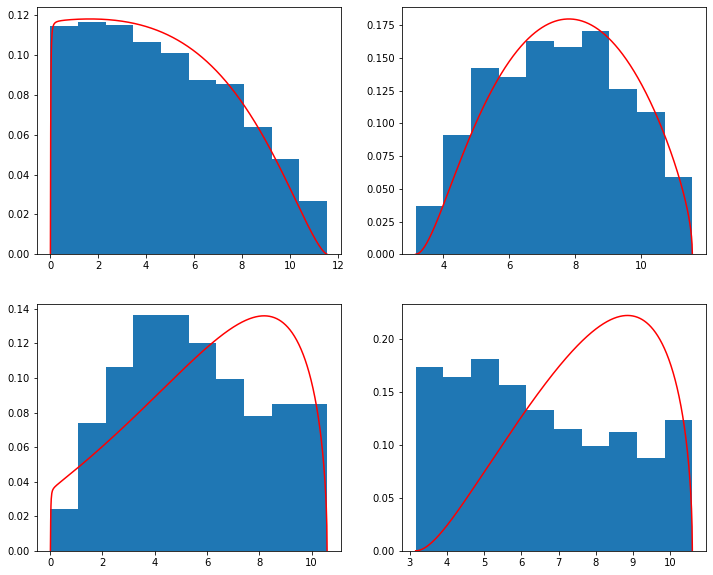

In [108]:
bins = 10

plt.figure(figsize=(12, 10))

# plot for mu
ax1 = plt.subplot(221)
range_mu = [0.105**2, 11.5532]
ax1.hist(df_train_o[df_train_o.target==1]['q2True'], bins=bins, density=True, range=range_mu);
q2_mu = np.linspace(range_mu[0], range_mu[1], 1000, endpoint=True)
dGmu = dGammaDsmu(q2_mu)
plt.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

# # plot for tau
ax2 = plt.subplot(222)
range_tau = [1.778**2, 11.5532]
bins=10
ax2.hist(df_train_o[df_train_o.target==0]['q2True'], bins=bins, density=True, range=range_tau);
q2_tau = np.linspace(range_tau[0], range_tau[1], 1000, endpoint=True)
dGtau = dGammaDstau(q2_tau)
plt.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# plot for tau
ax3 = plt.subplot(223)
range_star_mu = [0.105**2, 10.594999]
ax3.hist(df_train_o[df_train_o.target==3]['q2True'], bins=bins, density=True, range=range_star_mu);
q2_star_mu = np.linspace(range_star_mu[0], range_star_mu[1], 1000, endpoint=True)
dGstarmu = dGammaDsstarmu(q2_star_mu)
plt.plot(q2_star_mu, dGstarmu/np.trapz(dGstarmu, x=q2_star_mu), color='red', label='theoretical')

# plot for mu
range_star_tau = [1.778**2, 10.594999]
ax4 = plt.subplot(224)
ax4.hist(df_train_o[df_train_o.target==3]['q2True'], bins=bins, density=True, range=range_star_tau);
q2_star_tau = np.linspace(range_star_tau[0], range_star_tau[1], 1000, endpoint=True)
dGstartau = dGammaDsstartau(q2_star_tau)
plt.plot(q2_star_tau, dGstartau/np.trapz(dGstartau, x=q2_star_tau), color='red', label='theoretical')

In [109]:
# reweight according to q^2
def find_m_rw(dGamma, df_train, target, range_, bin_num=10):
    # get the truth q2 array
    q2 = df_train[df_train.target==target]['q2True'].values    

    # Simulated bins
    hist, bins = np.histogram(a=q2, bins=bin_num, density=True, range=range_)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    # Theoretical bins
    th_w = []
    for i in range(bin_num):
        dx = -(bins[i] - bins[i+1])/10
        x = np.linspace(bins[i], bins[i+1], 1000)
        y = dGamma(q2=x)
        th_w.append(np.trapz(y, dx=dx))    # Find area under curve
    # normalize
    th_w = th_w / sum(th_w) / width

    # reweighting
    m_rw = th_w / hist
    m_rw[np.isinf(m_rw)] = 0
    
    # return the values of each bin, and the bin bounds
    return m_rw, bins





# add the reweighting column to th dataframe
def add_m_rw(target, m_rw, bins, df):
    for i in range(len(bins)-1):
        df.loc[(df['target']==target) & (df['q2True']>=bins[i]) & (df['q2True']<bins[i+1]), 'm_rw'] = m_rw[i]
    
#     print(df.loc[df['target']==target, 'weight'].sum())
#     df.loc[df.target==target, 'm_rw'] = df.loc[df.target==target, 'm_rw']/(df.loc[df.target==target, 'm_rw'].sum())
    df.loc[df['target']==target, 'reweight'] = df.loc[df['target']==target, 'weight'] * df.loc[df.target==target, 'm_rw']
    df = df.drop(columns = ['m_rw'])
    
#     print(df.loc[df.target==target, 'reweight'].sum())
#     print()
    return df

In [110]:
# getting the weightings, and the bin bounds
m_rw_tau, bins_tau = find_m_rw(dGammaDstau, df_train_o, target=0, range_=range_tau)
m_rw_mu, bins_mu = find_m_rw(dGammaDsmu, df_train_o, target=1, range_=range_mu)
m_rw_star_tau, bins_star_tau = find_m_rw(dGammaDsstartau, df_train_o, target=2, range_=range_star_tau)
m_rw_star_mu, bins_star_mu = find_m_rw(dGammaDsstarmu, df_train_o, target=3, range_=range_star_mu)

# duplicate the column for inputting to the function to get the reweight column
df_train_o['reweight'] = df_train_o['weight']
df_train['reweight'] = df_train['weight']
df_test['reweight'] = df_test['weight']


df_train_o = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train_o)
df_train_o = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train_o)
df_train_o = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_train_o)
df_train_o = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_train_o)

df_train = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train)
df_train = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train)
df_train = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_train)
df_train = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_train)

df_test = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_test)
df_test = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_test)
df_test = add_m_rw(target=2, m_rw=m_rw_star_tau, bins=bins_star_tau, df=df_test)
df_test = add_m_rw(target=3, m_rw=m_rw_star_mu, bins=bins_star_mu, df=df_test)


In [111]:
m_rw_mu, m_rw_tau, m_rw_star_mu, m_rw_star_tau

(array([1.00482406, 1.01220359, 1.01551524, 1.06770369, 1.07090585,
        1.12527599, 0.98322914, 0.99582288, 0.78207355, 0.37166415]),
 array([0.39695268, 0.71453968, 0.80204917, 1.11120396, 1.05287989,
        1.12923559, 1.01298535, 1.19954518, 1.05671822, 0.97634359]),
 array([1.67614183, 0.743897  , 0.65475209, 0.62232002, 0.73675564,
        0.96022716, 1.29130261, 1.72793096, 1.51973151, 1.01213386]),
 array([2.34936613, 1.33375154, 1.62363453, 0.90111828, 0.95801457,
        0.97337419, 1.02263191, 1.08295259, 1.12982851, 0.68236377]))

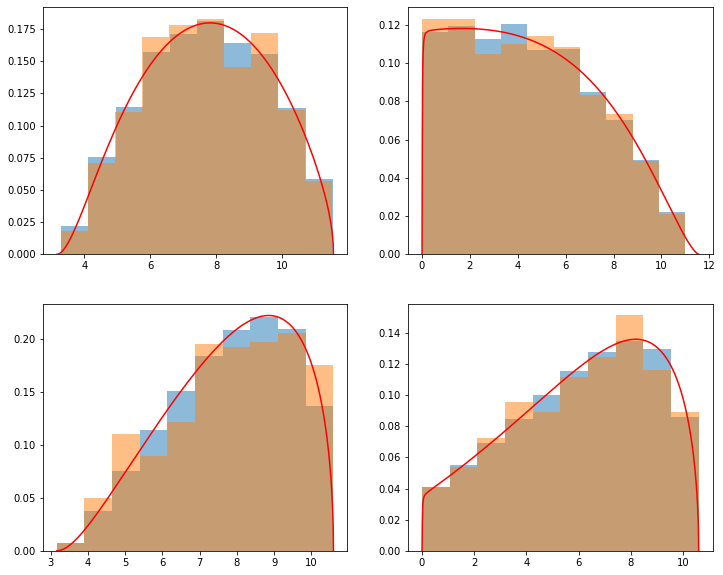

In [112]:
bins = 10

plt.figure(figsize=(12, 10))

# reweighted plot for tau, in testing 
ax1 = plt.subplot(221)
ax1.hist(df_train[df_train.target==0]['q2True'], bins=10, weights=df_train[df_train.target==0]['reweight'], density=True, alpha=0.5);
ax1.hist(df_test[df_test.target==0]['q2True'], bins=10, weights=df_test[df_test.target==0]['reweight'], density=True, alpha=0.5);
ax1.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# reweighted plot for mu, in testing 
ax2 = plt.subplot(222)
ax2.hist(df_train[df_train.target==1]['q2True'], bins=10, weights=df_train[df_train.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.hist(df_test[df_test.target==1]['q2True'], bins=10, weights=df_test[df_test.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

ax3 = plt.subplot(223)
ax3.hist(df_train[df_train.target==2]['q2True'], bins=10, weights=df_train[df_train.target==2]['reweight'], density=True, alpha=0.5, range=range_star_tau);
ax3.hist(df_test[df_test.target==2]['q2True'], bins=10, weights=df_test[df_test.target==2]['reweight'], density=True, alpha=0.5, range=range_star_tau);
ax3.plot(q2_star_tau, dGstartau/np.trapz(dGstartau, x=q2_star_tau), color='red', label='theoretical')

ax4 = plt.subplot(224)
ax4.hist(df_train[df_train.target==3]['q2True'], bins=10, weights=df_train[df_train.target==3]['reweight'], density=True, alpha=0.5, range=range_star_mu);
ax4.hist(df_test[df_test.target==3]['q2True'], bins=10, weights=df_test[df_test.target==3]['reweight'], density=True, alpha=0.5, range=range_star_mu);
ax4.plot(q2_star_mu, dGstarmu/np.trapz(dGstarmu, x=q2_star_mu), color='red', label='theoretical')

## BDT

In [65]:
# getting the inputs and labels
X_train = df_train[features]
y_train = np.array(df_train.target)

# getting the inputs and labels
X_test = df_test[features]
y_test = np.array(df_train.target)

In [66]:
# trainging
X_train = df_train[features]
y_train = np.array([relabel(i) for i in df_train['target']])

# testing
X_test = df_test[features]
y_test = np.array([relabel(i) for i in df_test['target']])

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.reweight.values);
# xgbc1.fit(X_train, y_train);

In [67]:
# transform the BDT output to score
def soft(prob, target):
    return np.exp(prob[:, target])/(np.exp(prob).sum(axis=1)) 

# scores for training
df_bdt_train_s = df_train[['target', 'reweight']]
df_bdt_train_s.loc[:, 'pred0'] = soft(xgbc1.predict_proba(X_train), 0)
df_bdt_train_s.loc[:, 'pred1'] = soft(xgbc1.predict_proba(X_train), 1)
df_bdt_train_s.loc[:, 'pred2'] = soft(xgbc1.predict_proba(X_train), 2)
df_bdt_train_s.loc[:, 'pred3'] = soft(xgbc1.predict_proba(X_train), 3)

# score for testing 
df_bdt_test_s = df_test[['target', 'reweight']]
df_bdt_test_s.loc[:, 'pred0'] = soft(xgbc1.predict_proba(X_test), 0)
df_bdt_test_s.loc[:, 'pred1'] = soft(xgbc1.predict_proba(X_test), 1)
df_bdt_test_s.loc[:, 'pred2'] = soft(xgbc1.predict_proba(X_test), 2)
df_bdt_test_s.loc[:, 'pred3'] = soft(xgbc1.predict_proba(X_test), 3)

## Finding the optimal position to cut

In [68]:
def bdt_cut(df, cut1, cut2, cut3, cut4, signal1=0, signal2=1, signal3=2, signal4=3):
    df1 = df[(df['pred0'] >= cut1) & (df['pred1'] < cut2) & (df['pred2'] < cut3) & (df['pred3'] < cut4)]    # pass tau cut, not pass mu cut
    df2 = df[(df['pred0'] < cut1) & (df['pred1'] >= cut2) & (df['pred2'] < cut3) & (df['pred3'] < cut4)]    # pass tau cut, not pass mu cut
    df3 = df[(df['pred0'] < cut1) & (df['pred1'] < cut2) & (df['pred2'] >= cut3) & (df['pred3'] < cut4)]    # pass tau cut, not pass mu cut
    df4 = df[(df['pred0'] < cut1) & (df['pred1'] < cut2) & (df['pred2'] < cut3) & (df['pred3'] >= cut4)]    # pass tau cut, not pass mu cut
    
    
    S1 = df1[df1['target'] == signal1]['reweight'].values.sum()    # Number of tau signals
    B1 = df1[df1['target'] != signal1]['reweight'].values.sum()    # Number of tau bkg.
#     B1 = df1[df1['target'] != signal1]['reweight'].values.sum() + df1[df1['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of tau bkg.
    
    S2 = df2[df2['target'] == signal2]['reweight'].values.sum()    # Number of mu signals
    B2 = df2[df2['target'] != signal2]['reweight'].values.sum()    # Number of mu bkg.
#     B2 = df2[df2['target'] != signal2]['reweight'].values.sum() + df2[df2['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of mu bkg.
        
    S3 = df3[df3['target'] == signal3]['reweight'].values.sum()    # Number of tau signals
    B3 = df3[df3['target'] != signal3]['reweight'].values.sum()    # Number of tau bkg.
#     B1 = df1[df1['target'] != signal1]['reweight'].values.sum() + df1[df1['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of tau bkg.
    
    S4 = df4[df4['target'] == signal4]['reweight'].values.sum()    # Number of mu signals
    B4 = df4[df4['target'] != signal4]['reweight'].values.sum()    # Number of mu bkg.
#     B2 = df2[df2['target'] != signal2]['reweight'].values.sum() + df2[df2['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of mu bkg.
    
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1))), \
        ((S2+B2)**0.5, (0.1*B2), S2/(np.sqrt(S2+B2))), \
        ((S3+B3)**0.5, (0.1*B3), S3/(np.sqrt(S3+B3))), \
        ((S4+B4)**0.5, (0.1*B4), S4/(np.sqrt(S4+B4)))





# looping to find the optimal cut
def find_opt_cut(df_bdt_train_s, point1=None, point2=None, point3=None, point4=None, step=0.005):
    if (point1 is None and point2 is None and point3 is None and point4 is None):
        point1 = (round(df_bdt_train_s.min()['pred0'], 2), round(df_bdt_train_s.max()['pred0'], 2))
        point2 = (round(df_bdt_train_s.min()['pred1'], 2), round(df_bdt_train_s.max()['pred1'], 2))
        point3 = (round(df_bdt_train_s.min()['pred2'], 2), round(df_bdt_train_s.max()['pred2'], 2))
        point4 = (round(df_bdt_train_s.min()['pred3'], 2), round(df_bdt_train_s.max()['pred3'], 2))
       
    
    # tau cut
    print(point1[0] - step, point1[1] + step, step)
    cuts1 = np.arange(point1[0] - step, point1[1] + step, step)
    # mu cut
    cuts2 = np.arange(point2[0] - step, point2[1] + step, step)
    # tau cut
    cuts3 = np.arange(point3[0] - step, point3[1] + step, step)
    # mu cut
    cuts4 = np.arange(point4[0] - step, point4[1] + step, step)
    
    # store cuts (tau, and mu)
    c1_lt, c2_lt, c3_lt, c4_lt = [], [], [], []
    # store losses
    loss11, loss12 = [], []
    loss21, loss22 = [], []
    loss31, loss32 = [], []
    loss41, loss42 = [], []
    snr1, snr2, snr3, snr4 = [], [], [], []

    # loop over two cuts
    for i1, c1 in enumerate(cuts1):
        for i2, c2 in enumerate(cuts2):
            for i3, c3 in enumerate(cuts3):
                for i4, c4 in enumerate(cuts4):
                    print("{}/{}; {}/{}; {}/{}; {}/{}".format(i1, len(cuts1), i2, len(cuts2), i3, len(cuts3), i4, len(cuts4)), end='\r')
                    res1, res2, res3, res4 = bdt_cut(df_bdt_train_s, c1, c2, c3, c4)
                    c1_lt.append(c1); c2_lt.append(c2); c3_lt.append(c3); c4_lt.append(c4)

                    loss11.append(res1[0]); loss12.append(res1[1])
                    loss21.append(res2[0]); loss22.append(res2[1])
                    loss31.append(res3[0]); loss32.append(res3[1])
                    loss41.append(res4[0]); loss42.append(res4[1])
                    snr1.append(res1[2]), snr2.append(res2[2]), snr3.append(res3[2]), snr4.append(res4[2])

    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c1_lt, c2_lt, c3_lt, c4_lt, 
                                loss11, loss12, snr1, 
                                loss21, loss22, snr2, 
                                loss31, loss32, snr3, 
                                loss41, loss42, snr4]).T
    df_bdt_loss.columns = ['c1', 'c2', 'c3', 'c4', 
                           'loss11', 'loss12', 'snr1', 
                           'loss21', 'loss22', 'snr2', 
                           'loss31', 'loss32', 'snr3', 
                           'loss41', 'loss42', 'snr4']

    df_bdt_loss['loss1'] = (df_bdt_loss['loss11']**2 + df_bdt_loss['loss12']**2)**0.5
    df_bdt_loss['tot1'] = (df_bdt_loss['loss1'] - df_bdt_loss['loss1'].min())/(df_bdt_loss['loss1'].max() - df_bdt_loss['loss1'].min()) - \
        ((df_bdt_loss['snr1'] - df_bdt_loss['snr1'].min())/(df_bdt_loss['snr1'].max() - df_bdt_loss['snr1'].min()))

    df_bdt_loss['loss2'] = (df_bdt_loss['loss21']**2 + df_bdt_loss['loss22']**2)**0.5
    df_bdt_loss['tot2'] = (df_bdt_loss['loss2'] - df_bdt_loss['loss2'].min())/(df_bdt_loss['loss2'].max() - df_bdt_loss['loss2'].min()) - \
        ((df_bdt_loss['snr2'] - df_bdt_loss['snr2'].min())/(df_bdt_loss['snr2'].max() - df_bdt_loss['snr2'].min()))

    df_bdt_loss['loss3'] = (df_bdt_loss['loss31']**2 + df_bdt_loss['loss32']**2)**0.5
    df_bdt_loss['tot3'] = (df_bdt_loss['loss3'] - df_bdt_loss['loss3'].min())/(df_bdt_loss['loss3'].max() - df_bdt_loss['loss3'].min()) - \
        ((df_bdt_loss['snr3'] - df_bdt_loss['snr3'].min())/(df_bdt_loss['snr3'].max() - df_bdt_loss['snr3'].min()))

    df_bdt_loss['loss4'] = (df_bdt_loss['loss41']**2 + df_bdt_loss['loss42']**2)**0.5
    df_bdt_loss['tot4'] = (df_bdt_loss['loss4'] - df_bdt_loss['loss4'].min())/(df_bdt_loss['loss4'].max() - df_bdt_loss['loss4'].min()) - \
        ((df_bdt_loss['snr4'] - df_bdt_loss['snr4'].min())/(df_bdt_loss['snr4'].max() - df_bdt_loss['snr4'].min()))

    df_bdt_loss['tot'] = df_bdt_loss['tot1'] + df_bdt_loss['tot2'] + df_bdt_loss['tot3'] + df_bdt_loss['tot4']

    return df_bdt_loss.iloc[df_bdt_loss['tot'].argmin()][['c1', 'c2', 'c3', 'c4']].values

In [69]:
%%time
step = 0.005
# c1, c2, c3, c4 = find_opt_cut(df_bdt_train_s, step=step*5)
# c1, c2, c3, c4 = find_opt_cut(df_bdt_train_s, 
#                               (c1-step*3, c1+step*3), 
#                               (c2-step*3, c2+step*3), 
#                               (c3-step*3, c3+step*3), 
#                               (c4-step*3, c4+step*3), step)

# print(np.array([c1, c2, c3, c4]))

# with Ks:
# c1, c2, c3, c4 = 0.275, 0.24,  0.315, 0.29

# without Ks:
c1, c2, c3, c4 = 0.28,  0.235, 0.305, 0.305

# wihtout Ks:
# 20 noise:
# c1, c2, c3, c4 = 0.26, 0.25, 0.295, 0.295

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [70]:
# apply the cut, to select tau and mu samples
df_bdt_test_s0_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] >= c1) & 
                                      (df_bdt_test_s['pred1'] <  c2) & 
                                      (df_bdt_test_s['pred2'] <  c3) & 
                                      (df_bdt_test_s['pred3'] <  c4)]

df_bdt_test_s1_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] < c1) & 
                                      (df_bdt_test_s['pred1'] >=  c2) & 
                                      (df_bdt_test_s['pred2'] <  c3) & 
                                      (df_bdt_test_s['pred3'] <  c4)]

df_bdt_test_s2_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] < c1) & 
                                      (df_bdt_test_s['pred1'] <  c2) & 
                                      (df_bdt_test_s['pred2'] >=  c3) & 
                                      (df_bdt_test_s['pred3'] <  c4)]

df_bdt_test_s3_cut = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] < c1) & 
                                      (df_bdt_test_s['pred1'] <  c2) & 
                                      (df_bdt_test_s['pred2'] <  c3) & 
                                      (df_bdt_test_s['pred3'] >=  c4)]


In [71]:
# Grouping the bkg. types
df_bdt_test_s0_cut['target'] = df_test_o.loc[df_bdt_test_s0_cut.index]['target']
df_bdt_test_s1_cut['target'] = df_test_o.loc[df_bdt_test_s1_cut.index]['target']
df_bdt_test_s2_cut['target'] = df_test_o.loc[df_bdt_test_s2_cut.index]['target']
df_bdt_test_s3_cut['target'] = df_test_o.loc[df_bdt_test_s3_cut.index]['target']

## Calculating the yields

In [72]:
def cal_uncertainty(df, channel, channel_labels):
    n_lt = []
    for i in channel_labels.keys():
        # Select the signal/bkg. 
        dfi = df[df.target==i]
        if len(dfi) == 0:
            ni = 0
        else: 
            # reweighted number 
            ni = dfi.reweight.sum() / (1-tr_te_split)
        # Print out the table
        if i==channel:
            print('(*Signal)  {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        else:
            print('(*Bkg.)    {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        
        n_lt.append(ni)
    # Estimate the Fake-Lambda_c Bkg.
#     n_fakeLambdac = n_lt[1]*0.28/100
#     n_lt.append(n_fakeLambdac)
#     print('(*Bkg.)  {}:\t{:.2e}'.format('Fake-Lambdac', n_fakeLambdac))
    
    
    print('.'*60)
    s = n_lt[channel]    # Number of signals
    b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
    Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
    u = 1/Z    # Uncertainty
    print("# of Siganl ({}):\t\t{:.2e}".format(channel_labels[channel], s))
    print("# of Bkg. for {}:\t\t{:.2e}".format(channel_labels[channel], (b-s)))
    print('Significance for {}:\t{:.0f}'.format(channel_labels[channel], Z))
    print('Uncertainty for {}:\t\t{:.5e} ({:.2e})'.format(channel_labels[channel], u, u))
    print('Uncertainty at {}:\t{:.5e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
    print('S/B for {}:\t\t\t{:.2f}'.format(channel_labels[channel], s/(b-s)))
    print('\n'+'='*60+'\n'*5)
    print()

    u10 = 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)
    return u, u10, n_lt


In [73]:
CHANNEL_LABELS = {0: 'Ds tau', 1: 'Ds mu', 2: 'Ds* tau', 3: 'Ds* mu', 4: 'Inclusive', 5: 'Comb.+Casc.', 6: 'MisID',}
uFull_tau, uFull_tau10, n_lt_tau = cal_uncertainty(df_bdt_test_s0_cut, 0, CHANNEL_LABELS)
uFull_mu, uFull_mu10, n_lt_mu = cal_uncertainty(df_bdt_test_s1_cut, 1, CHANNEL_LABELS)


# print("Overall Uncertainty: {:.2e}".format((uFull_mu**2 + uFull_tau**2)**0.5))
# print("Overall Uncertainty 10-Tera Z: {:.2e}".format((uFull_mu10**2 + uFull_tau10**2)**0.5))
# print("\n"*5)


uFull_star_tau, uFull_star_tau10, n_lt_star_tau = cal_uncertainty(df_bdt_test_s2_cut, 2, CHANNEL_LABELS)
uFull_star_mu, uFull_star_mu10, n_lt_star_mu = cal_uncertainty(df_bdt_test_s3_cut, 3, CHANNEL_LABELS)


# print("Overall Uncertainty: {:.2e}".format((uFull_star_tau**2 + uFull_star_mu**2)**0.5))
# print("Overall Uncertainty 10-Tera Z: {:.2e}".format((uFull_star_tau10**2 + uFull_star_mu10**2)**0.5))

(*Signal)  Ds tau:		1.96e+05
(*Bkg.)    Ds mu:		4.68e+04
(*Bkg.)    Ds* tau:		1.02e+05
(*Bkg.)    Ds* mu:		7.43e+04
(*Bkg.)    Inclusive:		3.43e+04
(*Bkg.)    Comb.+Casc.:		5.03e+04
(*Bkg.)    MisID:		3.87e+03
............................................................
# of Siganl (Ds tau):		1.96e+05
# of Bkg. for Ds tau:		3.11e+05
Significance for Ds tau:	260
Uncertainty for Ds tau:		3.84608e-03 (3.85e-03)
Uncertainty at 10 TeraZ:	1.21624e-03 (1.22e-03)
S/B for Ds tau:			0.63







(*Bkg.)    Ds tau:		5.36e+04
(*Signal)  Ds mu:		7.53e+06
(*Bkg.)    Ds* tau:		3.26e+04
(*Bkg.)    Ds* mu:		5.25e+06
(*Bkg.)    Inclusive:		4.46e+05
(*Bkg.)    Comb.+Casc.:		1.46e+05
(*Bkg.)    MisID:		6.51e+04
............................................................
# of Siganl (Ds mu):		7.53e+06
# of Bkg. for Ds mu:		6.00e+06
Significance for Ds mu:	1892
Uncertainty for Ds mu:		5.28657e-04 (5.29e-04)
Uncertainty at 10 TeraZ:	1.67176e-04 (1.67e-04)
S/B for Ds mu:			1.26







(*Bkg.)    Ds tau:		1.56

In [74]:
df_bdt_test_s0_cut['q2'] = df_test_o.loc[df_bdt_test_s0_cut.index]['q2']
df_bdt_test_s1_cut['q2'] = df_test_o.loc[df_bdt_test_s1_cut.index]['q2']
df_bdt_test_s2_cut['q2'] = df_test_o.loc[df_bdt_test_s2_cut.index]['q2']
df_bdt_test_s3_cut['q2'] = df_test_o.loc[df_bdt_test_s3_cut.index]['q2']

In [75]:
def binbybin_correction(df_train, cut):
    Cs = {}
    for i in np.unique(df_train.target):
        dfi = df_train[df_train.target == i]
        N_q2Low = dfi[dfi.q2 < cut]['reweight'].sum()
        N_q2High = dfi[dfi.q2 >= cut]['reweight'].sum()
        N_q2truthLow = dfi[dfi.q2True < cut]['reweight'].sum()
        N_q2truthHigh = dfi[dfi.q2True >= cut]['reweight'].sum()
        Cs[i] = [N_q2truthLow/N_q2Low, N_q2truthHigh/N_q2High]
    return Cs

In [76]:
df_train['target'] = df_train_o.loc[df_train.index]['target']

In [77]:
Cs = binbybin_correction(df_train, 7.15)
Cs[4] = [1, 1]
Cs[5] = [1, 1]
Cs[6] = [1, 1]
Cs

{0: [1.1382171649731088, 0.928560737553074],
 1: [1.0050987516411642, 0.9808518363388768],
 2: [1.1431420686817402, 0.9391909628393893],
 3: [0.9614580337758756, 1.0627866839497992],
 4: [1, 1],
 5: [1, 1],
 6: [1, 1]}

In [78]:
def diff_measurement(df, q2_cut, Cs, channel):
    def _cal_uncertainty_(df, channel, channel_labels, Cs, region):
        n_lt = []
        for i in channel_labels.keys():
            # Select the signal/bkg. 
            dfi = df[df.target==i]
            if len(dfi) == 0:
                ni = 0
            else: 
                # reweighted number 
                ni = dfi.reweight.sum() / (1-tr_te_split) * Cs[i][region]
            # Print out the table
            if i==channel:
                print('(*Signal)  {}:\t{:.5e}'.format(channel_labels[i], ni))
            else:
                print('(*Bkg.)    {}:\t{:.5e}'.format(channel_labels[i], ni))

            n_lt.append(ni)
        # Estimate the Fake-J/psi Bkg.
#         n_fakeDs = n_lt[3]/26.23729
#         n_lt.append(n_fakeDs)
#         print('(*Bkg.)    {}:\t{:.5e}'.format('Fake-Ds', n_fakeDs))


        print('.'*40)
        s = n_lt[channel]    # Number of signals
        b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
        Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
        u = 1/Z    # Uncertainty
        print("# of Siganl ({}):     {:.5e}".format(channel_labels[channel], s))
        print("# of Bkg. for {}:     {:.5e}".format(channel_labels[channel], (b-s)))
        print('Significance for {}:  {:.0f}'.format(channel_labels[channel], Z))
        print('Uncertainty for {}:\t\t{:.5e} ({:.2e})'.format(channel_labels[channel], u, u))
        print('Uncertainty at {}:\t{:.5e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
        print('S/B for {}:\t\t\t{:.2f}'.format(channel_labels[channel], s/(b-s)))
        print(s, (b-s))
        print('\n'+'='*40)

        return u, n_lt
    
    
    dfLow = df[df.q2 < q2_cut]
    dfHigh = df[df.q2 >= q2_cut]
    
    print('#####   q^2 < 7.15   #####')
    print()
    u_Low, n_lt_low = _cal_uncertainty_(dfLow, channel, CHANNEL_LABELS, Cs, 0)
    print()
    print('#####   q^2 >= 7.15   #####')    
    print()
    u_High, n_lt_high = _cal_uncertainty_(dfHigh, channel, CHANNEL_LABELS, Cs, 1)
    
    return u_Low, u_High, n_lt_low, n_lt_high
    

In [79]:
uLow0, uHigh0, n_lt_low0, n_lt_high0 = diff_measurement(df_bdt_test_s0_cut, 7.15, Cs, 0)

#####   q^2 < 7.15   #####

(*Signal)  Ds tau:	5.04214e+04
(*Bkg.)    Ds mu:	3.22332e+04
(*Bkg.)    Ds* tau:	2.61623e+04
(*Bkg.)    Ds* mu:	4.08678e+04
(*Bkg.)    Inclusive:	1.37340e+04
(*Bkg.)    Comb.+Casc.:	1.14351e+04
(*Bkg.)    MisID:	1.32711e+03
........................................
# of Siganl (Ds tau):     5.04214e+04
# of Bkg. for Ds tau:     1.25760e+05
Significance for Ds tau:  115
Uncertainty for Ds tau:		8.69661e-03 (8.70e-03)
Uncertainty at 10 TeraZ:	2.75011e-03 (2.75e-03)
S/B for Ds tau:			0.40
50421.40051714601 125759.53120544381


#####   q^2 >= 7.15   #####

(*Signal)  Ds tau:	1.41064e+05
(*Bkg.)    Ds mu:	1.44179e+04
(*Bkg.)    Ds* tau:	7.42294e+04
(*Bkg.)    Ds* mu:	3.37664e+04
(*Bkg.)    Inclusive:	2.06011e+04
(*Bkg.)    Comb.+Casc.:	3.88792e+04
(*Bkg.)    MisID:	2.53982e+03
........................................
# of Siganl (Ds tau):     1.41064e+05
# of Bkg. for Ds tau:     1.84434e+05
Significance for Ds tau:  232
Uncertainty for Ds tau:		4.31014e-03 (4.31e

In [80]:
uLow1, uHigh1, n_lt_low1, n_lt_high1 = diff_measurement(df_bdt_test_s1_cut, 7.15, Cs, 1)

#####   q^2 < 7.15   #####

(*Bkg.)    Ds tau:	3.57504e+04
(*Signal)  Ds mu:	6.23741e+06
(*Bkg.)    Ds* tau:	2.79874e+04
(*Bkg.)    Ds* mu:	3.60116e+06
(*Bkg.)    Inclusive:	3.11305e+05
(*Bkg.)    Comb.+Casc.:	1.32647e+05
(*Bkg.)    MisID:	5.89193e+04
........................................
# of Siganl (Ds mu):     6.23741e+06
# of Bkg. for Ds mu:     4.16777e+06
Significance for Ds mu:  1777
Uncertainty for Ds mu:		5.62727e-04 (5.63e-04)
Uncertainty at 10 TeraZ:	1.77950e-04 (1.78e-04)
S/B for Ds mu:			1.50
6237406.122139263 4167768.43105401


#####   q^2 >= 7.15   #####

(*Bkg.)    Ds tau:	2.05974e+04
(*Signal)  Ds mu:	1.29978e+06
(*Bkg.)    Ds* tau:	7.63374e+03
(*Bkg.)    Ds* mu:	1.60149e+06
(*Bkg.)    Inclusive:	1.35051e+05
(*Bkg.)    Comb.+Casc.:	1.37221e+04
(*Bkg.)    MisID:	6.15506e+03
........................................
# of Siganl (Ds mu):     1.29978e+06
# of Bkg. for Ds mu:     1.78465e+06
Significance for Ds mu:  696
Uncertainty for Ds mu:		1.43771e-03 (1.44e-03)
Uncer

In [81]:
uLow2, uHigh2, n_lt_low2, n_lt_high2 = diff_measurement(df_bdt_test_s2_cut, 7.15, Cs, 2)

#####   q^2 < 7.15   #####

(*Bkg.)    Ds tau:	2.89977e+03
(*Bkg.)    Ds mu:	3.62403e+03
(*Signal)  Ds* tau:	1.97923e+04
(*Bkg.)    Ds* mu:	3.59525e+04
(*Bkg.)    Inclusive:	4.57802e+03
(*Bkg.)    Comb.+Casc.:	9.14805e+03
(*Bkg.)    MisID:	2.74575e+02
........................................
# of Siganl (Ds* tau):     1.97923e+04
# of Bkg. for Ds* tau:     5.64769e+04
Significance for Ds* tau:  69
Uncertainty for Ds* tau:		1.45219e-02 (1.45e-02)
Uncertainty at 10 TeraZ:	4.59224e-03 (4.59e-03)
S/B for Ds* tau:			0.35
19792.26355790363 56476.90278011834


#####   q^2 >= 7.15   #####

(*Bkg.)    Ds tau:	1.20953e+04
(*Bkg.)    Ds mu:	1.21406e+03
(*Signal)  Ds* tau:	1.62341e+05
(*Bkg.)    Ds* mu:	8.64348e+04
(*Bkg.)    Inclusive:	2.06011e+04
(*Bkg.)    Comb.+Casc.:	6.86104e+03
(*Bkg.)    MisID:	2.42541e+03
........................................
# of Siganl (Ds* tau):     1.62341e+05
# of Bkg. for Ds* tau:     1.29632e+05
Significance for Ds* tau:  278
Uncertainty for Ds* tau:		3.60264e-03

In [82]:
uLow3, uHigh3, n_lt_low3, n_lt_high3 = diff_measurement(df_bdt_test_s3_cut, 7.15, Cs, 3)

#####   q^2 < 7.15   #####

(*Bkg.)    Ds tau:	4.93023e+03
(*Bkg.)    Ds mu:	3.92826e+05
(*Bkg.)    Ds* tau:	4.68768e+04
(*Signal)  Ds* mu:	5.70199e+06
(*Bkg.)    Inclusive:	1.87699e+05
(*Bkg.)    Comb.+Casc.:	6.86104e+04
(*Bkg.)    MisID:	1.24016e+04
........................................
# of Siganl (Ds* mu):     5.70199e+06
# of Bkg. for Ds* mu:     7.13344e+05
Significance for Ds* mu:  2002
Uncertainty for Ds* mu:		4.99506e-04 (5.00e-04)
Uncertainty at 10 TeraZ:	1.57958e-04 (1.58e-04)
S/B for Ds* mu:			7.99
5701985.823654472 713343.8234212883


#####   q^2 >= 7.15   #####

(*Bkg.)    Ds tau:	2.53989e+03
(*Bkg.)    Ds mu:	1.25915e+05
(*Bkg.)    Ds* tau:	9.96189e+03
(*Signal)  Ds* mu:	4.20722e+06
(*Bkg.)    Inclusive:	1.23606e+05
(*Bkg.)    Comb.+Casc.:	4.57403e+03
(*Bkg.)    MisID:	2.33389e+03
........................................
# of Siganl (Ds* mu):     4.20722e+06
# of Bkg. for Ds* mu:     2.68931e+05
Significance for Ds* mu:  1759
Uncertainty for Ds* mu:		5.68552e-04 (5.69

In [39]:
RDs_ = 0.392931
RDsLow = 0.196073
RDsHigh = 1.15284

RDsstar_ = 0.302752
RDsstarLow = 0.170282
RDsstarHigh = 0.495824

In [40]:
def asy_form(s, b):
    return (2*((s+b)*np.log(1+s/b)-s))**0.5

def rss(a, b):
    return (a**2 + b**2)**0.5


In [41]:
def getCorr(n_lt_tau, n_lt_star_tau, RDs, RDsstar, percentage=0.005):

    x = n_lt_tau[0]
    bx = sum(n_lt_tau) - x
    y = n_lt_star_tau[2]
    by = sum(n_lt_star_tau) - y

    eps_y = n_lt_tau[2] / y
    eps_x = n_lt_star_tau[0] / x

    bx_other = bx - y*eps_y
    by_other = by - x*eps_x

    print('x: {:.5e}\t bx: {:.5e}\t {:.5e}'.format(x, bx, eps_y*y))
    print('y: {:.5e}\t by: {:.5e}\t {:.5e}'.format(y, by, eps_x*x))
    
    
#     ====================================================================

    plt.figure(figsize=(8,8))

    f = []

    x_min = x-percentage*x
    x_max = x+percentage*x+0.00000001
    y_min = y-percentage*y
    y_max = y+percentage*y+0.00000001
    # y_min = y-percentage/1.5*y
    # y_max = y+percentage/1.5*y+0.0000001

    n_steps = 1000
    xran = np.linspace(x_min, x_max, n_steps)
    yran = np.linspace(y_min, y_max, n_steps)

    for xi in xran:
        fx = []
        for yi in yran:

            bx_tot = bx_other + x + eps_y*y
            by_tot = by_other + y + eps_x*x

            fx.append(rss(asy_form(bx_other + xi + eps_y*yi - bx_tot, bx_tot), asy_form(by_other + yi + eps_x*xi - by_tot, by_tot)))

        f.append(fx)

    f = np.array(f).T

    x_2d, y_2d = np.meshgrid(xran, yran)

    f[f>1] = 0
    
    ax1 = plt.subplot(221)
    ax1.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f)
#     ax1.colorbar()
    ax1.axhline(RDsstar, color='yellow')
    ax1.axvline(RDs, color='yellow')
#     ax1.xlabel('number of Ds tau')
#     ==============================================================================
    f_ = f.copy()
#     f_ = []

    a = np.argmax(f_, axis=1)
    a[a==0] = 9999
    i_x_min, i_x_max = min(a), max(np.argmax(f_, axis=1))
#     x_min, x_max = xran[i_x_min], xran[i_x_max]

    b = np.argmax(f_, axis=0)
    b[b==0] = 9999
    i_y_min, i_y_max = min(b), max(np.argmax(f_, axis=0))
#     y_min, y_max = yran[i_y_min], yran[i_y_max]
    
    
    i_x_closest = min([n_steps/2 - i_x_min, i_x_max - n_steps/2])
    i_y_closest = min([n_steps/2 - i_y_min, i_y_max - n_steps/2])
    
    x_min, x_max = xran[int(n_steps/2 - i_x_closest)], xran[int(n_steps/2 + i_x_closest)]
    y_min, y_max = yran[int(n_steps/2 - i_y_closest)], yran[int(n_steps/2 + i_y_closest)]
    
    ax2 = plt.subplot(222)
    ax2.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f_)
#     ax2.colorbar()

    ax2.axhline(y_min*RDsstar/y, color='yellow')
    ax2.axhline(y_max*RDsstar/y, color='yellow')
    ax2.axvline(x_min*RDs/x, color='yellow')
    ax2.axvline(x_max*RDs/x, color='yellow')

#     ax2.xlabel('R(Ds)')
#     ax2.ylabel('R(Ds*)');

# =========================================================================================
    f = []

    frac = 0.005
#     xran = np.linspace(x_min - (x_max-x_min)*frac, x_max + (x_max-x_min)*frac, 750)
#     yran = np.linspace(y_min - (y_max-y_min)*frac, y_max + (y_max-y_min)*frac, 750)


    xran = np.linspace(x_min - (x_max-x_min)*frac, x_max + (x_max-x_min)*frac, 1000)
    yran = np.linspace(y_min - (y_max-y_min)*frac, y_max + (y_max-y_min)*frac, 1000)


    
    for xi in xran:
        fx = []
        for yi in yran:

            bx_tot = bx_other + x + eps_y*y
            by_tot = by_other + y + eps_x*x 

            fx.append(rss(asy_form(bx_other + xi + eps_y*yi - bx_tot, bx_tot), asy_form(by_other + yi + eps_x*xi - by_tot, by_tot)))

        f.append(fx)

    f = np.array(f).T

    x_2d, y_2d = np.meshgrid(xran, yran)

    f[f>1] = 0
    
    ax3 = plt.subplot(223)
    ax3.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f)

#     ===============================================================================
    f_ = f.copy()

    f_[f_>1] = 0
    a = np.argmax(f_, axis=1)
    a[a==0] = 9999
    i_x_min, i_x_max = min(a), max(np.argmax(f_, axis=1))
    x_min, x_max = xran[i_x_min], xran[i_x_max]

    b = np.argmax(f_, axis=0)
    b[b==0] = 9999
    i_y_min, i_y_max = min(b), max(np.argmax(f_, axis=0))
    y_min, y_max = yran[i_y_min], yran[i_y_max]
    
    ax4 = plt.subplot(223)
    ax4.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f_)
    
    ax4.axhline(RDsstar, color='yellow')
    ax4.axvline(RDs, color='yellow')
    ax4.axhline(y_max*RDsstar/y, color='yellow')
    ax4.axvline(x_min*RDs/x, color='yellow')
#     ============================================================================================
    pho_y1 = yran[np.argmax(f_[:, i_x_min])]
    pho_y2 = yran[np.argmax(f_[:, i_x_max])]

    pho_x1 = xran[np.argmax(f_[i_y_max, :])]
    pho_x2 = xran[np.argmax(f_[i_y_min, :])]
    
    ax5 = plt.subplot(224)
    ax5.contourf(x_2d*RDs/x, y_2d*RDsstar/y, f_)
    

    # plt.axhline(y_min)
    ax5.axhline(y_max*RDsstar/y, color='yellow')

    for ii, z in enumerate(f_[:, int(f_.shape[0]/2)][::-1]):
        if z != 0:
            print(ii)
            break


    ax5.axhline(yran[-ii]*RDsstar/y, color='yellow')
    ax5.axvline(xran[int(f_.shape[0]/2)]*RDs/x, color='yellow')
    ax5.axhline(yran[int(f_.shape[1]/2)]*RDsstar/y, color='yellow')
#     ===================================================================================
    sigma_inner = (yran[np.argmax(f_[:, int(f_.shape[1]/2)])] - yran[int(f_.shape[1]/2)])*RDsstar/y
    sigma_i = (y_max - yran[int(f_.shape[1]/2)])*RDsstar/y

    rho_xy = (1-(sigma_inner/sigma_i)**2)**0.5 * -1
    
    sigma_Ds = x_max*RDs/x - RDs
    sigma_Dsstar = y_max*RDsstar/y - RDsstar
    
    plt.show()
    
    
    print('R(Ds):  {:.2e}'.format(sigma_Ds/RDs))
    print('R(Ds*): {:.2e}'.format(sigma_Dsstar/RDsstar))
    print('rho:    {:.2f}'.format(rho_xy))
    print('rho:    {:.5f}'.format(rho_xy))

In [42]:
500-63, 500-19

(437, 481)

x: 1.96216e+05	 bx: 3.11485e+05	 1.01922e+05
y: 1.90166e+05	 by: 1.83027e+05	 1.55735e+04
71


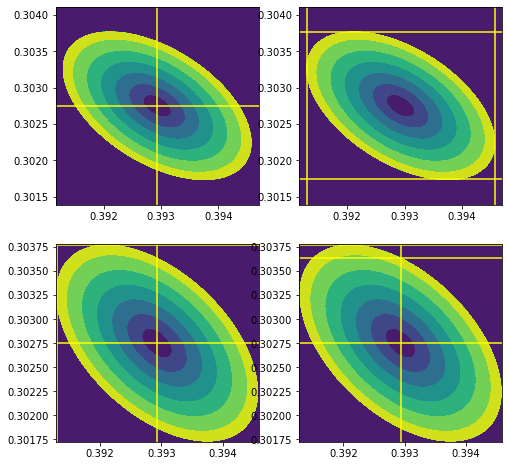

R(Ds):  4.17e-03
R(Ds*): 3.36e-03
rho:    -0.50
rho:    -0.49936
CPU times: user 13 s, sys: 40.1 ms, total: 13.1 s
Wall time: 13.1 s


In [43]:
%%time
getCorr(n_lt_tau, n_lt_star_tau, RDs_, RDsstar_, 0.0045)

x: 1.96216e+06	 bx: 3.11485e+06	 1.01922e+06
y: 1.90166e+06	 by: 1.83027e+06	 1.55735e+05
72


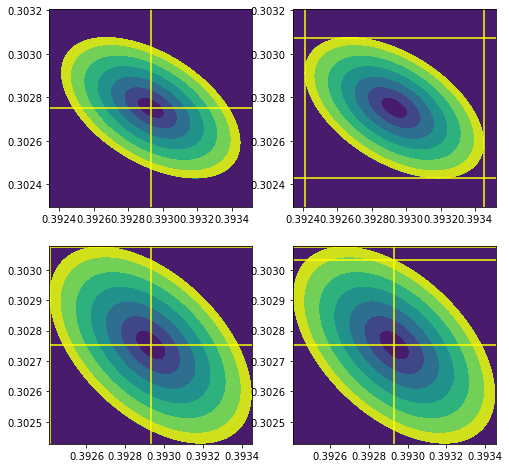

R(Ds):  1.32e-03
R(Ds*): 1.06e-03
rho:    -0.49


In [158]:
getCorr([i*10 for i in n_lt_tau], [i*10 for i in n_lt_star_tau], RDs_, RDsstar_, 0.0015)

x: 5.04214e+04	 bx: 1.25760e+05	 2.61623e+04
y: 1.97923e+04	 by: 5.64769e+04	 2.89977e+03
157


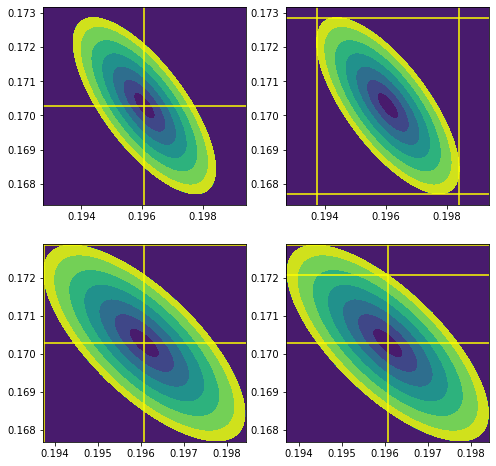

R(Ds):  1.19e-02
R(Ds*): 1.52e-02
rho:    -0.72


In [159]:
getCorr(n_lt_low0, n_lt_low2, RDsLow, RDsstarLow, 0.017)

x: 5.04214e+05	 bx: 1.25760e+06	 2.61623e+05
y: 1.97923e+05	 by: 5.64769e+05	 2.89977e+04
157


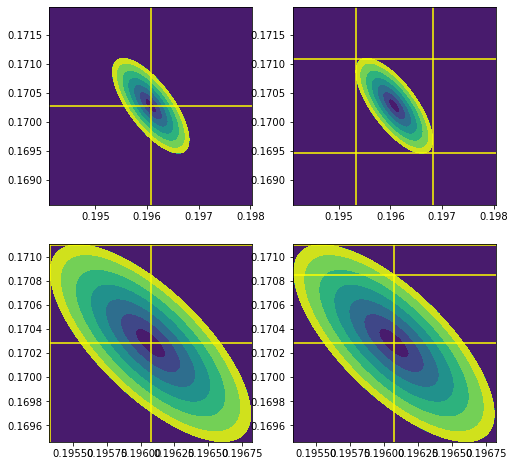

R(Ds):  3.77e-03
R(Ds*): 4.79e-03
rho:    -0.71


In [160]:
getCorr([i*10 for i in n_lt_low0], [i*10 for i in n_lt_low2], RDsLow, RDsstarLow, 0.01)

x: 1.41064e+05	 bx: 1.84434e+05	 7.42294e+04
y: 1.62341e+05	 by: 1.29632e+05	 1.20953e+04
82


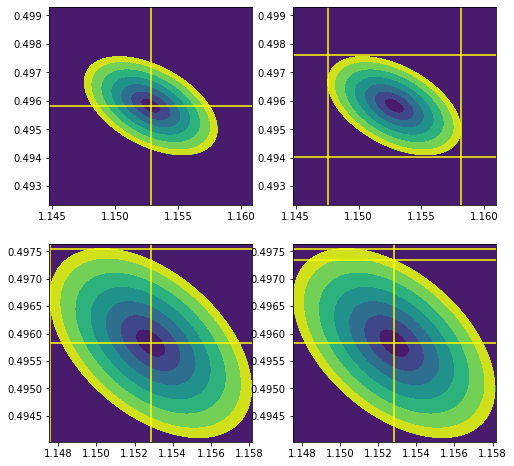

R(Ds):  4.58e-03
R(Ds*): 3.48e-03
rho:    -0.47


In [161]:
getCorr(n_lt_high0, n_lt_high2, RDsHigh, RDsstarHigh, 0.007)

x: 1.48958e+06	 bx: 2.53821e+06	 7.54224e+05
y: 1.07618e+06	 by: 7.62706e+05	 7.84900e+04
71


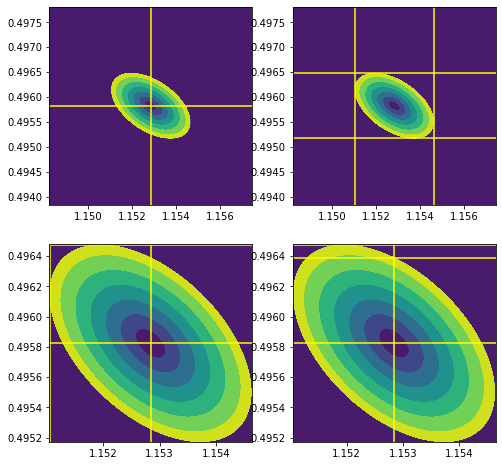

R(Ds):  1.56e-03
R(Ds*): 1.31e-03
rho:    -0.48


In [47]:
getCorr([i*10 for i in n_lt_high0], [i*10 for i in n_lt_high2], RDsHigh, RDsstarHigh, 0.004)

x: 1.97306e+05	 bx: 4.62809e+05	 9.31971e+04
y: 1.19924e+05	 by: 9.55455e+04	 8.80986e+03
64


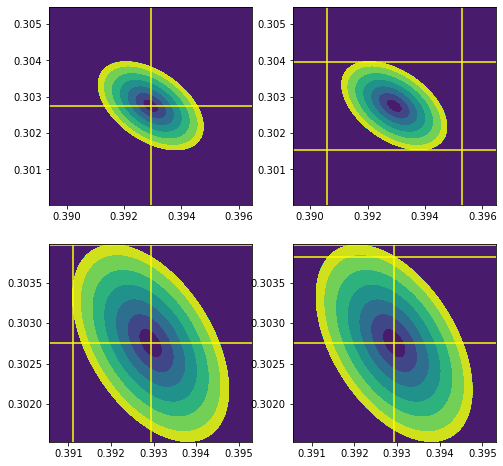

R(Ds):  4.66e-03
R(Ds*): 4.02e-03
rho:    -0.48
rho:    -0.47721


In [54]:
getCorr(n_lt_tau, n_lt_star_tau, RDs_, RDsstar_, 0.009)

In [50]:
'{:.4f}'.format(4.66/4.17-1)

'0.1175'

In [51]:
'{:.4f}'.format(4.02/3.36-1)

'0.1964'

In [46]:
'{:.4f}'.format(-.48/-.50-1)

'-0.0400'

## Saving Plots

In [113]:
df_plot = df_test

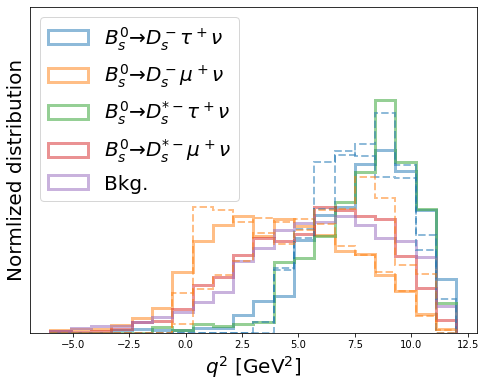

In [114]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-6,12]
bins_=20
ax1.margins(y=0.4)


ax1.hist(df_plot[(df_plot.target==0)]['q2'], weights=df_plot[df_plot.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['q2'], weights=df_plot[df_plot.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target==2)]['q2'], weights=df_plot[df_plot.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['q2'], weights=df_plot[df_plot.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['q2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=2, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['q2True'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['q2True'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
ax1.hist(df_plot[(df_plot.target==2)]['q2True'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==3)]['q2True'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/Dsq2')
f.savefig('./figures/Dsq2_20noise')

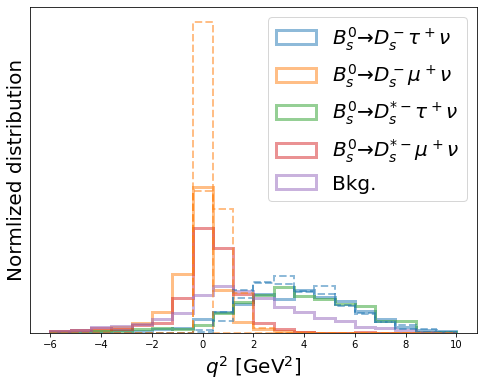

In [115]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-6,10]

# ax1.margins(y=0.3)


ax1.hist(df_plot[(df_plot.target==0)]['miss2'], weights=df_plot[df_plot.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['miss2'], weights=df_plot[df_plot.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target==2)]['miss2'], weights=df_plot[df_plot.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['miss2'], weights=df_plot[df_plot.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['miss2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=1, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['miss2True'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['miss2True'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
ax1.hist(df_plot[(df_plot.target==2)]['miss2True'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==3)]['miss2True'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/Dsmiss2')
f.savefig('./figures/Dsmiss2_20noise')


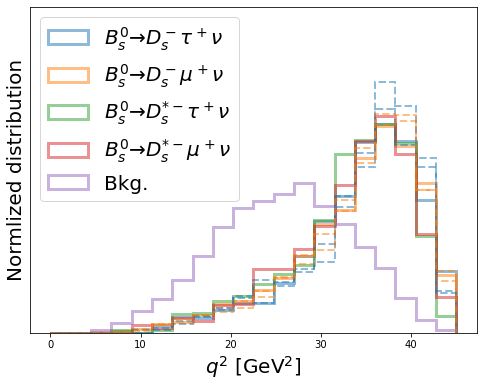

In [116]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,45]

ax1.margins(y=0.3)


ax1.hist(df_plot[(df_plot.target==0)]['EB'], weights=df_plot[df_plot.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot[(df_plot.target==1)]['EB'], weights=df_plot[df_plot.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');
ax1.hist(df_plot[(df_plot.target==2)]['EB'], weights=df_plot[df_plot.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax1.hist(df_plot[(df_plot.target==3)]['EB'], weights=df_plot[df_plot.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['EB'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=2, fontsize=20)
ax1.hist(df_plot[(df_plot.target==0)]['EBTrue'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==1)]['EBTrue'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');
ax1.hist(df_plot[(df_plot.target==2)]['EBTrue'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
ax1.hist(df_plot[(df_plot.target==3)]['EBTrue'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
ax1.set_yticks([])

# f.savefig('./figures/DsEB')
f.savefig('./figures/DsEB_20noise')



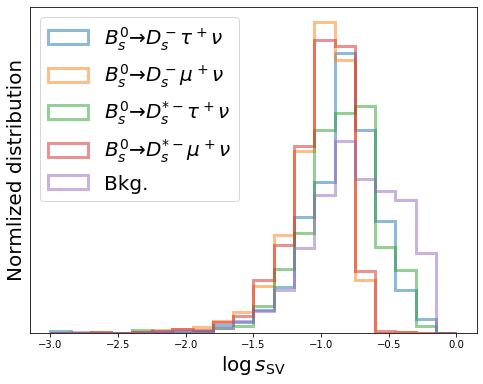

In [117]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[-3,0]


ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuBVert']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuBVert']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==2)]['sMinMuBVert']), weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target==3)]['sMinMuBVert']), weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(np.log10(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['sMinMuBVert']), weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);

ax1.legend(loc=2, fontsize=20)
# ax1.hist(np.log10(df_plot[(df_plot.target==0)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C0', linestyle='--');
# ax1.hist(np.log10(df_plot[(df_plot.target==1)]['sMinMuHcVertTrue']), weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, alpha=0.5, color='C1', linestyle='--');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\log{s_{\rm SV}}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)

# f.savefig('./figures/Dslogssv')
f.savefig('./figures/Dslogssv_20noise')



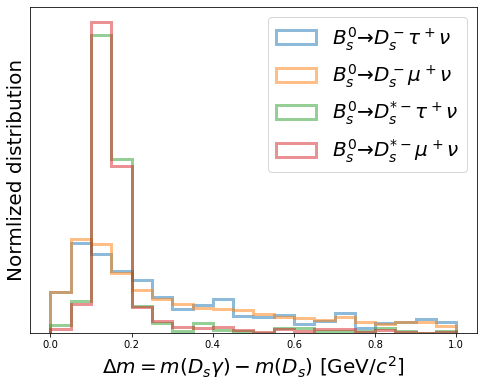

In [118]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
range_=[0,1]


ax1.hist(df_plot[(df_plot.target==0)]['DeltaM'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['DeltaM'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['DeltaM'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['DeltaM'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['DeltaM'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$\Delta m=m(D_s\gamma)-m(D_s)$ [GeV$/c^2$]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/Dsdeltam')
# f.savefig('./figures/Dsdeltam_20noise')


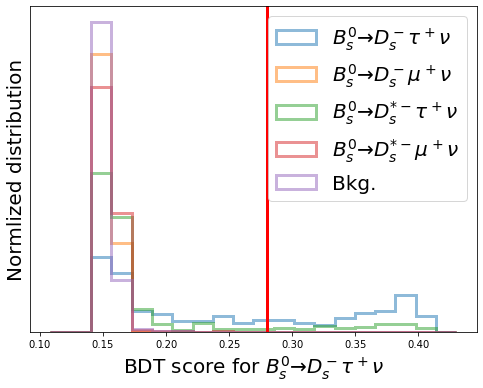

In [93]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
df_plot = df_bdt_test_s
pred0_max = df_plot[(df_plot.target==0)]['pred0'].max() 
pred0_min = df_plot[(df_plot.target==0)]['pred0'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]


ax1.hist(df_plot[(df_plot.target==0)]['pred0'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred0'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['pred0'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['pred0'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pred0'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score for $B_s^0\to D_s^- \tau^+\nu$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.axvline(c1, color='red', lw=3)

f.savefig('./figures/DstauBDT')


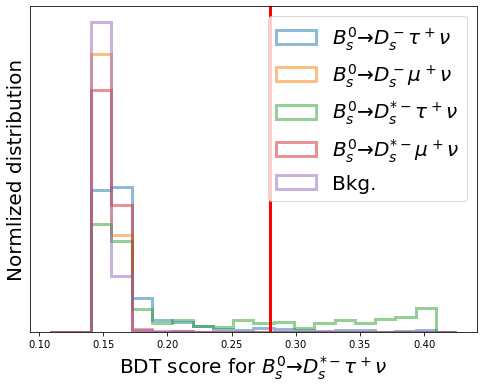

In [94]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
df_plot = df_bdt_test_s
pred0_max = df_plot[(df_plot.target==0)]['pred2'].max() 
pred0_min = df_plot[(df_plot.target==0)]['pred2'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]


ax1.hist(df_plot[(df_plot.target==0)]['pred2'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==1)]['pred2'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==2)]['pred2'], weights=df_plot[df_plot.target==2]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==3)]['pred2'], weights=df_plot[df_plot.target==3]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5);
ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pred2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5);
ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score for $B_s^0\to D_s^{*-} \tau^+\nu$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.axvline(c1, color='red', lw=3)

f.savefig('./figures/DsstartauBDT')


In [247]:
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))

{'DeltaM': 2114.0,
 'miss2': 1910.0,
 'q2': 1846.0,
 'pB': 1819.0,
 'sMinMuBVert': 1631.0,
 'pHc': 1226.0,
 'mHcMu': 1186.0,
 'pMu': 1184.0,
 'sMinMuHcVert': 1169.0,
 'sPVHc': 1117.0,
 'mCorr': 1082.0,
 'pPerp': 1046.0,
 'ENeutral06': 649.0,
 'ENeutral03': 581.0,
 'sMinMuTr': 537.0,
 'sMinHcTr': 527.0,
 'ENeutral06Photon': 492.0,
 'ECharge06': 479.0,
 'ECharge06PV': 450.0,
 'ENeutral03Photon': 420.0,
 'ENeutral06Hadron': 370.0,
 'ECharge03': 343.0,
 'ECharge03PV': 343.0,
 'ENeutral03Hadron': 326.0,
 'ECharge03DV': 218.0,
 'ECharge06DV': 209.0,
 'D0Max': 179.0,
 'DzMax': 149.0,
 'EHc': 133.0,
 'DzSum': 128.0,
 'D0Sum': 109.0}

In [60]:
df_plot0 = df_test.loc[df_bdt_test_s0_cut.index]
df_plot2 = df_test.loc[df_bdt_test_s2_cut.index]
# df_plot = df_test

[]

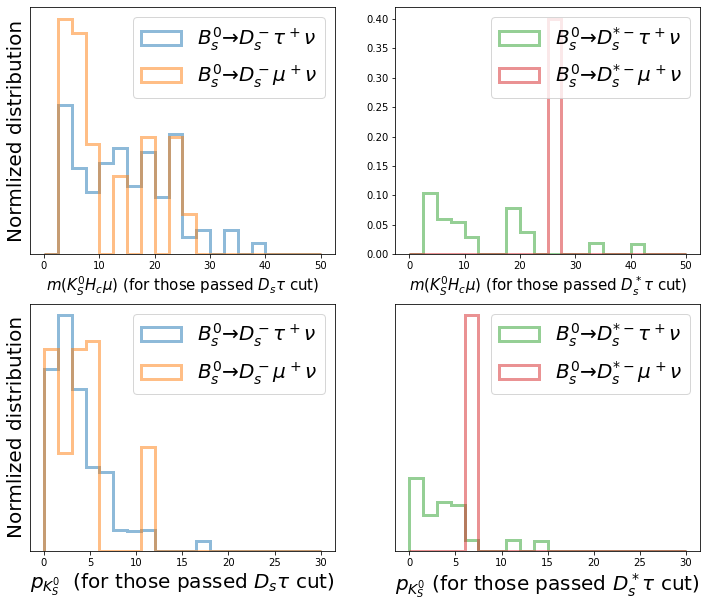

In [75]:
f = plt.figure(figsize=(12,10))
# ax1 = plt.subplot(111)
range_=[0, 50]

# ax1.margins(y=0.3)
bins_=20

# plt.
ax1 = plt.subplot(221)
ax1.hist(df_plot0[(df_plot0.target==0)]['mK0SHcMu'], weights=df_plot0[df_plot0.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax1.hist(df_plot0[(df_plot0.target==1)]['mK0SHcMu'], weights=df_plot0[df_plot0.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');


ax2 = plt.subplot(222)
ax2.hist(df_plot2[(df_plot2.target==2)]['mK0SHcMu'], weights=df_plot2[df_plot2.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax2.hist(df_plot2[(df_plot2.target==3)]['mK0SHcMu'], weights=df_plot2[df_plot2.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pK0S'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m(K^0_S H_c \mu)$ (for those passed $D_s\tau$ cut)', fontsize=15)
ax2.set_xlabel(r'$m(K^0_S H_c \mu)$ (for those passed $D_s^* \tau$ cut)', fontsize=15)
ax1.set_yticks([])
ax3.set_yticks([])


range_=[0, 30]

ax3 = plt.subplot(223)
ax3.hist(df_plot0[(df_plot0.target==0)]['pK0S'], weights=df_plot0[df_plot0.target==0]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \tau^+\nu$', alpha=0.5, color='C0');
ax3.hist(df_plot0[(df_plot0.target==1)]['pK0S'], weights=df_plot0[df_plot0.target==1]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^- \mu^+\nu$', alpha=0.5, color='C1');


ax4 = plt.subplot(224)
ax4.hist(df_plot2[(df_plot2.target==2)]['pK0S'], weights=df_plot2[df_plot2.target==2]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \tau^+\nu$', alpha=0.5, color='C2');
ax4.hist(df_plot2[(df_plot2.target==3)]['pK0S'], weights=df_plot2[df_plot2.target==3]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'$B_s^0\to D_s^{*-} \mu^+\nu$', alpha=0.5, color='C3');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['pK0S'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)&(df_plot.target!=2)&(df_plot.target!=3)]['reweight'], bins=bins_, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C4');

ax1.legend(loc=1, fontsize=20)
ax2.legend(loc=1, fontsize=20)
ax3.legend(loc=1, fontsize=20)
ax4.legend(loc=1, fontsize=20)

ax3.set_ylabel('Normlized distribution', fontsize=20)
ax3.set_xlabel(r'$p_{K^0_S}$  (for those passed $D_s\tau$ cut)', fontsize=20)
ax4.set_xlabel(r'$p_{K^0_S}$ (for those passed $D_s^*\tau$ cut)', fontsize=20)
ax3.set_yticks([])
ax4.set_yticks([])

# f.savefig('./Lambdab_plot/LambdabpK0S')
# f.savefig('./Lambdab_plot/LambdabpK0S_20noise')


In [93]:
print("fraction of events that contains reconstructed K0s:")
print("Ds tau:  {:.2f}\nDs mu:   {:.2f}\nDs* tau: {:.2f}\nDs* mu:  {:.2f}\n".format(
    1-len(df_test[(df_test.target==0) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==0)]),\
    1-len(df_test[(df_test.target==1) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==1)]),\
    1-len(df_test[(df_test.target==2) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==2)]),\
    1-len(df_test[(df_test.target==3) & (df_test.pK0S.isna())]) / len(df_test[(df_test.target==3)])))

fraction of events that contains reconstructed K0s:
Ds tau:  0.27
Ds mu:   0.28
Ds* tau: 0.29
Ds* mu:  0.29



0.7064220183486238